# Model Selection
Evaluating and selecting algorithms and hyperparameters.

In [2]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Hyperparameter tuning
Now that we know how to evaluate models, we can improve them by tuning their hyperparameters

We can basically use any optimization technique to optimize hyperparameters:
    
- __Grid search__
- __Random search__
- Local search
- Racing algorithms
- __Model-based optimization__
- Multi-armed bandits
- Genetic algorithms

## Model-based optimization

- After a number of random search iterations we know more about the performance of hyperparameter settings on the given dataset
- We can use this data to train a model, and predict which other hyperparameter values might be useful
- This is often a probabilistic (e.g. Bayesian) model that predicts confidence intervals for all hyperparameter settings


Example: Bayesian optimization (see figure): 

- Consider only 1 continuous hyperparameter (X-axis)
- Y-axis shows cross-validation performance
- Evaluate a number of random hyperparameter settings (black dots)
    - Sometimes an initialization design is used
- Train a model, and predict the expected performance of other (unseen) hyperparameter values
    - Mean value (black line) and distribution (blue band)
- An _acquisition function_ (green line) trades off maximal expected performace and maximal uncertainty
    - Exploitation vs exploration
- Optimal value of the asquisition function is the next hyperparameter setting to be evaluated
- Repeat a fixed number of times, or until time budget runs out

![BayesOpt](images/03_Bayesian_optimization.png)

## Evaluation Metrics and scoring
Keep the end-goal in mind

### Metrics for binary classification

- The most common (and simple) application of machine learning in practice
- We have a positive and a negative class
- Different kind of errors:
    - False Positive (type I error): model predicts positive while the true label is negative
    - False Negative (type II error): model predicts negative while the true label is positive
- Which side do you want to err on for a medical test?

#### Imbalanced datasets

- The type of error plays an even larger role if the dataset is imbalanced
    - One class is much more frequent than the other
    - This is often typical of real world data
    - E.g. credit card fraud detection
- Is a 99.99% accuracy good enough? 

- Let's create an imbalanced dataset from the handwritten digits dataset by classifying the digit 9 against all others.
- Is 90% accuracy still good? Can we do better?

In [33]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.tar get == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

In [83]:
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression
 
# Always predicts majority class
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score (accuracy): {:.2f}".format(dummy.score(X_test, y_test)))

dummy score (accuracy): 0.90


In [84]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score (accuracy): {:.2f}".format(logreg.score(X_test, y_test)))

logreg score (accuracy): 0.98


#### Confusion matrices

- We can represent all predictions (correct and incorrect) in a confusion matrix
    - n by n array (n is the number of classes)
    - Rows correspond to the true classes
    - Columns correspond to the predicted classes
    - Each entry counts how often a sample that belongs to the class corresponding to the row was classified as the class corresponding to the column.

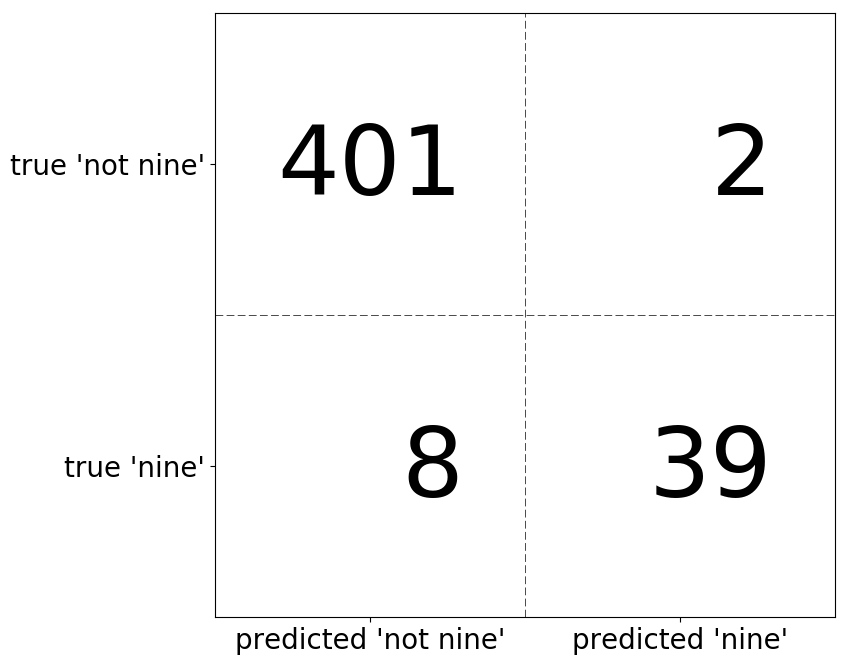

In [36]:
mglearn.plots.plot_confusion_matrix_illustration()

The confusion matrix can be constructed from the true labels and predcitions as follows:

In [37]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion)) 

Confusion matrix:
[[401   2]
 [  8  39]]


For binary classification, we use the following terms:

- True Negative (TN)
- False Positive (FP)
- False Negative (FN)
- True Positive (TP)

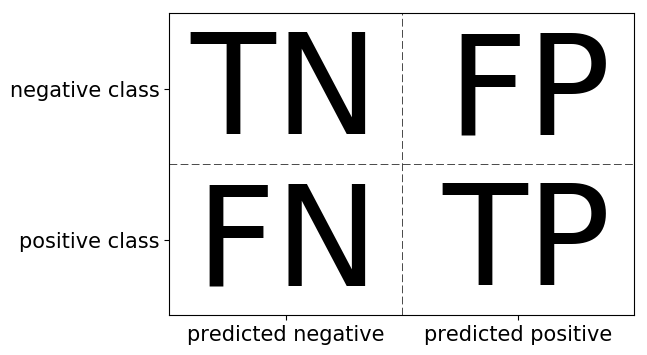

In [38]:
mglearn.plots.plot_binary_confusion_matrix()

It's often useful to compare the confusion matrices of classifiers:
- The dummy classifier always predicts the same class, produces a large number of FNs.
- Logistic regression produces more FPs, but much fewer FNs.

In [39]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_dummy))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg)) 

Most frequent class:
[[403   0]
 [ 47   0]]

Logistic Regression
[[401   2]
 [  8  39]]


The results of the confusion matrix can be summarized in several ways

- We already know accuracy:

\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

__Precision__ is used when the goal is to limit FPs
- Clinical trails: you only want to test drugs that really work
- Search engines: you want to avoid bad search results

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

In [80]:
from sklearn.metrics import precision_score
print("precision score most frequent: {:.2f}".format(
    precision_score(y_test, pred_dummy)))
print("precision score logistic regression: {:.2f}".format(
    precision_score(y_test, pred_logreg)))

precision score most frequent: 0.00
precision score logistic regression: 0.95


__Recall__ is used when the goal is to limit FNs
- Cancer diagnosis: you don't want to miss a serious disease
- Search engines: You don't want to omit important hits
- Also know as sensitivity, hit rate, true positive rate (TPR)

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

In [81]:
from sklearn.metrics import recall_score
print("recall score most frequent: {:.2f}".format(
    recall_score(y_test, pred_dummy)))
print("recall score logistic regression: {:.2f}".format(
    recall_score(y_test, pred_logreg)))

recall score most frequent: 0.00
recall score logistic regression: 0.83


__F1-score__ or F1-measure trades off precision and recall:

\begin{equation}
\text{F1} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{equation}

In [40]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_test, pred_dummy)))
print("f1 score logistic regression: {:.2f}".format(
    f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score logistic regression: 0.89


- To study the scores _by class_, use `classification_report`
    - One class viewed as positive, others als negative
    - Support: number of samples in each class
    - Last line: weighted average over the classes (weighted by number of samples in each class)

In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_dummy,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.90      1.00      0.94       403
       nine       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



In [42]:
print(classification_report(y_test, pred_logreg,
                            target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.98      1.00      0.99       403
       nine       0.95      0.83      0.89        47

avg / total       0.98      0.98      0.98       450



#### Taking uncertainty into account

- Remember that many classifiers actually return a probability per class
    - We can retrieve it with `decision_function` and `predict_proba`
- For binary classification, we threshold at 0 for  `decision_function` and 0.5 for `predict_proba` by default
- However, depending on the evaluation measure, you may want to threshold differently to fit your goals
    - For instance, when a FP is much worse than a FN
    - This is called _threshold calibration_

##### Visualization
- Imagine that we want to avoid misclassifying a red point
- The black line shows the threshold: points within are classified positive (red)
- By changing the decision treshold, more points will be classified positive

In [43]:
from mglearn.datasets import make_blobs 
X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],        
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)                                     

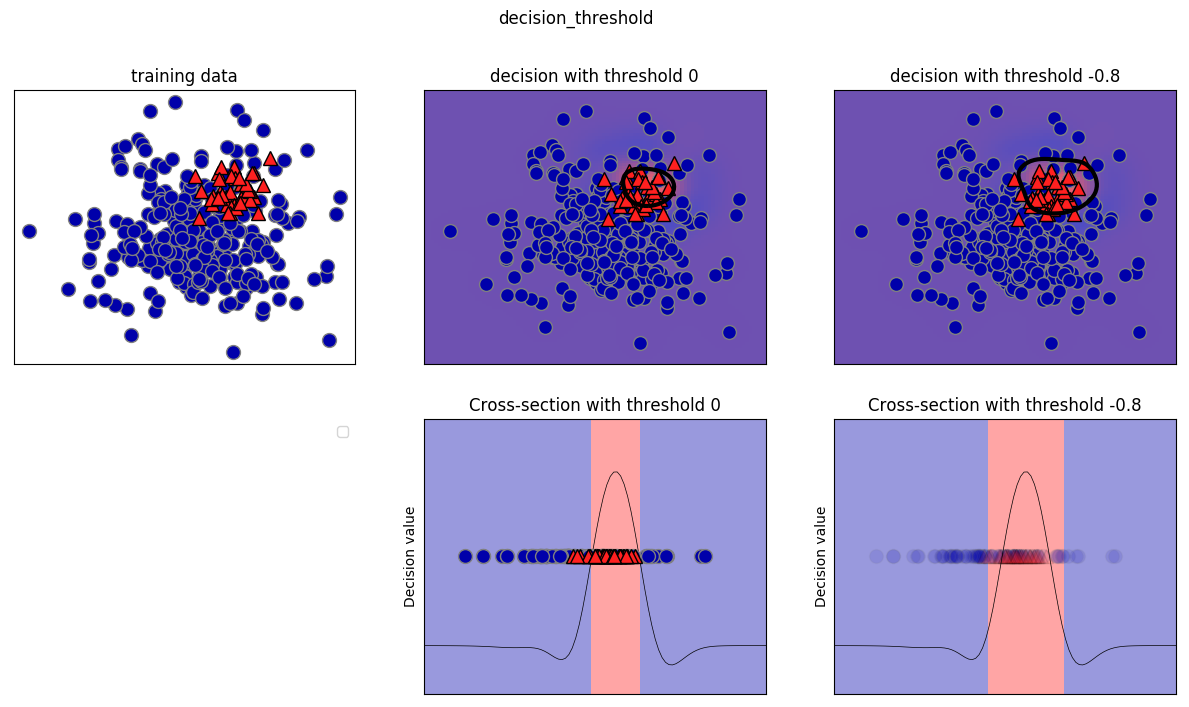

In [44]:
mglearn.plots.plot_decision_threshold()

- Studying the classification report, we see that lowering the threshold yields:
    - higher recall for class 1 (we risk more FPs in exchange for more TP)
    - lower precision for class 1
- We can often trade off precision for recall

In [45]:
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



In [46]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8
print(classification_report(y_test, y_pred_lower_threshold))  

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



### Precision-Recall curves

- The right threshold depends on your application, should be driven by business goals.
- You can have arbitrary high recall, but you often want reasonable precision, too.
- It is not clear beforehand where the optimale trade-off (or _operating point_) will be, so it is useful to look at all possible thresholds
- Plotting precision against recall for all thresholds yields a __precision-recall curve__
 


- In scikit-learn, this is included in the `sklearn.metrics` module
- Returns all precision and recall values for all thresholds

In [86]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

- Now we can plot the curve.
- The default tradeoff (chosen by the `predict` method) is shown as _threshold zero_.
- The closer the curve stays to the upper-right corner, the better
    - High precision and high recall
- Here, it is possible to still get a precision of 0.5 with high recall

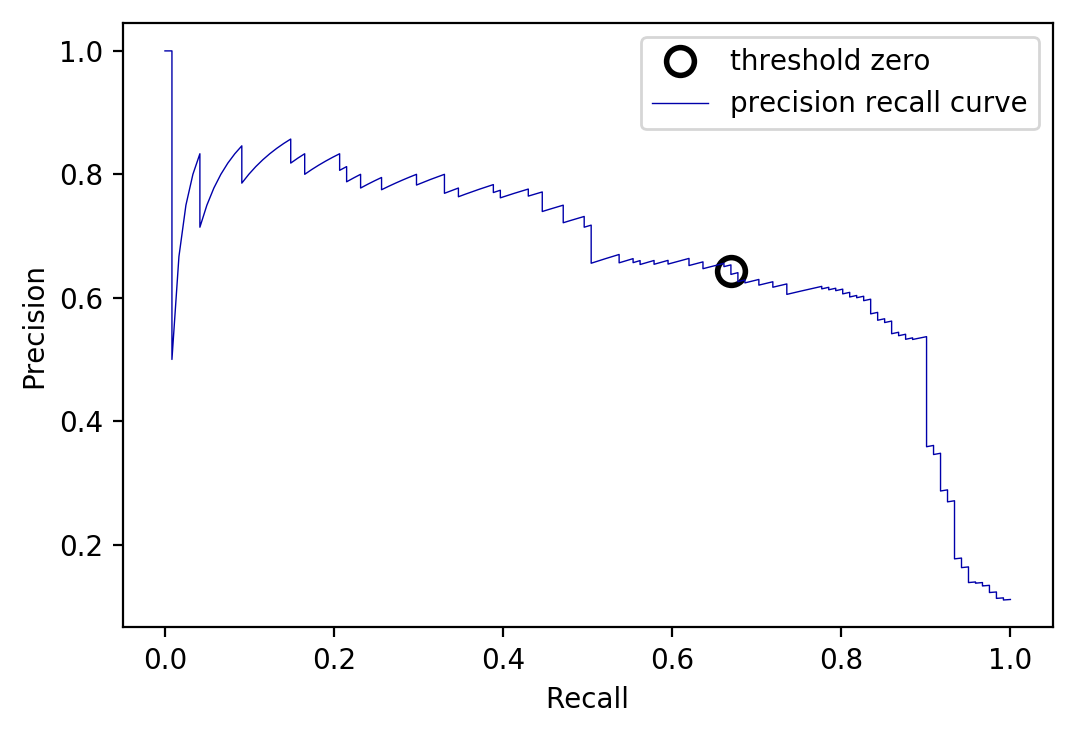

In [87]:
plt.rcParams['savefig.dpi'] = 200 # Use 300 for PDF, 100 for slides
# create a similar dataset as before, but with more samples
# to get a smoother curve
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(recall, precision, label="precision recall curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

#### Model selection

- Different classifiers work best in different parts of the curve (at different operating points)
- Let's compare two classifiers (we'll see both soon)
- The RandomForest (in red) performs better at the extremes
- The area under the precision-recall curve (AUPRC) is often used as a general evaluation measure

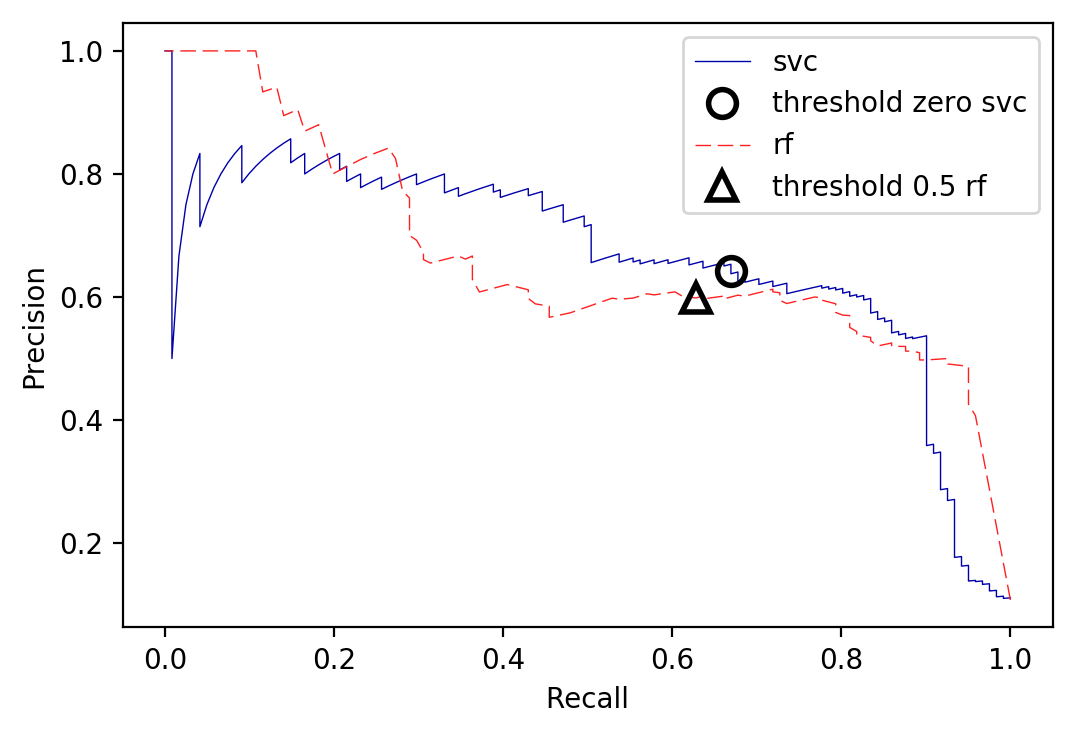

In [88]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
# Only pass probabilities for the positive class
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(recall, precision, label="svc")

plt.plot(recall[close_zero], precision[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(recall_rf, precision_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot( recall_rf[close_default_rf], precision_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best");

Note that the F1-measure completely misses these subtleties

In [50]:
print("f1_score of random forest: {:.3f}".format(
        f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


- The area under the precision-recall curve is returned by the `average_precision_score` measure 
    - It's actually a close approximation of the actual area
- This is a good automatic measure, but also hides the subtleties

In [51]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


### Receiver Operating Characteristics (ROC) and AUC

- There is another trade-off between recall (true positive rate, TPR) and the false positive rate (FPR).
- The 2D space created by TPR and FPR is called the Receiver Operating Characteristics (ROC) space
- A model will be at one point in this ROC space

\begin{equation}
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\end{equation}

- Varying the decision threshold yields the ROC curve
- It can be computed with the `roc_curve` function
- Ideal is close to the top left: high recall, low FPR
- Inspect the curve to find the preferred calibration
    - Here, we can get much higher recall with slightly worse FPR

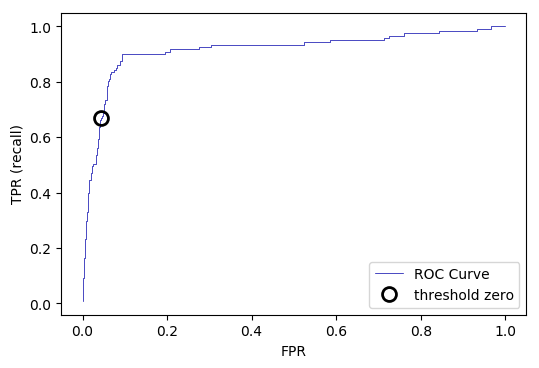

In [92]:
plt.rcParams['savefig.dpi'] = 100 # Use 300 for PDF, 100 for slides
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4);

#### Visualization

- The blue probability density shows the probability p(x) that the model predicts blue if a data point has a certain predicted probability x to be blue. Same for red.
- In a random classifier the probability densities completely overlap.
- All points with a predicted probability higher than the threshold are predicted positive, others negative
- As we increase the threshold, we'll get fewer FPs, more FNs. We move from right to left along the ROC curve.

![roc](images/03_roc.png)

#### ROC Isometrics
- Different _costs_ can be involved for FP and FN
- This yields different _isometrics_ (lines of equal cost) in ROC space
- The optimal threshold is the point on the ROC curve where the cost in minimal
    - If a FP and FN are weigthed equally, cost lines follow the diagonal (blue line)
    - If a FP is 10 times worse than a FN: pink line
    - IF a FN is 10 times worse than a FP: red line

![ROC cost curves](images/03_roc_cost.png)

#### Model selection

- Again, we can compare multiple models by looking at the ROC curves
- We can calibrate the threshold depending on whether we need high recall or low FPR
- We can select between algorithms (or hyperparameters) depending on the involved costs.

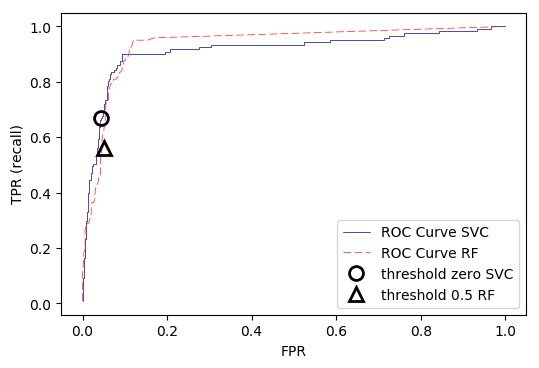

In [53]:
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4);

#### Area under the ROC curve

- A good summary measure is the area under the ROC curve (AUROC or AUC)
- Compute using the `roc_auc_score` 
    - Don't use `auc` (uses less accurate trapezoidal rule)

In [54]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


#### Imbalanced classes
- AUC is popular because it is insensitive to class imbalance
    - Random guessing yields TPR=FPR no matter what the class imbalance is
    - All points are on the diagonal line, hence an AUC of 0.5
    - Hint: use the visualization of TPR,FPR to see this
- Example: unbalanced digits
    - 3 models, ACC is the same, AUC not
    - If we optimize for ACC, our model could be just random guessing

gamma = 1.000  accuracy = 0.90  AUC = 0.5000
gamma = 0.100  accuracy = 0.90  AUC = 0.9582
gamma = 0.010  accuracy = 0.90  AUC = 0.9995


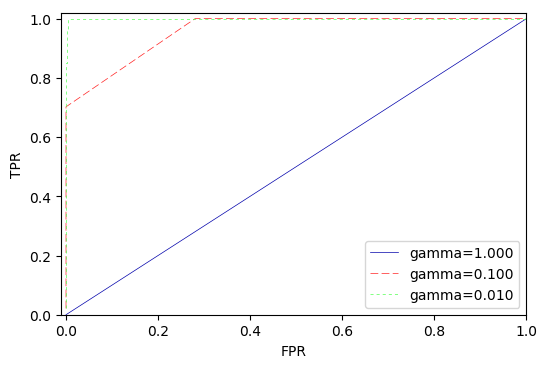

In [55]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()  

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.3f}  accuracy = {:.2f}  AUC = {:.4f}".format(
            gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

#### Take home message

- AUC is highly recommended, especially on imbalanced data
- Remember to calibrate the threshold to your needs

### Multi-class classification

- Multiclass metrics are derived from binary metrics, averaged over all classes
- Let's consider the full (10-class) handwritten digit recognition data

Confusion matrix

In [56]:
from sklearn.metrics import accuracy_score
digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


Visualized as a heatmap

- Which digits are easy to predict? Which ones are confused? 

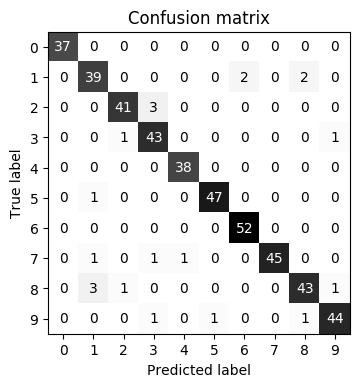

In [57]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

Precision, recall, F1-score

- Now yield 10 per-class scores

In [58]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.89      0.91      0.90        43
          2       0.95      0.93      0.94        44
          3       0.90      0.96      0.92        45
          4       0.97      1.00      0.99        38
          5       0.98      0.98      0.98        48
          6       0.96      1.00      0.98        52
          7       1.00      0.94      0.97        48
          8       0.93      0.90      0.91        48
          9       0.96      0.94      0.95        47

avg / total       0.95      0.95      0.95       450



Different ways to compute average

- macro-averaging: computes unweighted per-class scores: 
$\frac{\sum_{i=0}^{n}score_i}{n}$
    - Use when you care about each class equally much

- weighted averaging: scores are weighted by the relative size of the classes (support): 
$\frac{\sum_{i=0}^{n}score_i weight_i}{n}$
    - Use when data is imbalanced

- micro-averaging: computes total number of FP, FN, TP over all classes, then computes scores using these counts: 
$recall = \frac{\sum_{i=0}^{n}TP_i}{\sum_{i=0}^{n}TP_i + \sum_{i=0}^{n}FN_i}$
    - Use when you care about each sample equally much

In [59]:
print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
print("Weighted average f1 score: {:.3f}".format(f1_score(y_test, pred, average="weighted")))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

Micro average f1 score: 0.953
Weighted average f1 score: 0.953
Macro average f1 score: 0.954


## Regression metrics

Most commonly used are
- (root) mean squared error: $\frac{\sum_{i}(y_{pred_i}-y_{actual_i})^2}{n}$
- mean absolute error: $\frac{\sum_{i}|y_{pred_i}-y_{actual_i}|}{n}$
    - Less sensitive to outliers and large errors
- R squared (r2)
    - Ratio of variation explained by the model / total variation
    - Always between 0 and 1, easier to interpret (higher is better)
    - Does not measure bias. Look at the residuals (see bias-variance decomposition).

## Using evaluation metrics in model selection

- You typically want to use AUC or other relevant measures in `cross_val_score` and `GridSearchCV` instead of the default accuracy.
- scikit-learn makes this easy through the `scoring` argument
    - But, you need to need to look the [mapping between the scorer and the metric](http://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation)

![scorers](images/03_scoring.png)

Or simply look up like this:

In [60]:
from sklearn.metrics.scorer import SCORERS
print("Available scorers:\n{}".format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']


Cross-validation with accuracy and AUC

In [61]:
# default scoring for classification is accuracy
print("Default scoring: {}".format(
      cross_val_score(SVC(), digits.data, digits.target == 9)))
# providing scoring="accuracy" doesn't change the results
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9, 
                                     scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))
roc_auc =  cross_val_score(SVC(), digits.data, digits.target == 9,
                           scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.9 0.9 0.9]
Explicit accuracy scoring: [0.9 0.9 0.9]
AUC scoring: [0.994 0.99  0.996]


Grid Search with accuracy and AUC

- With accuracy, gamma=0.0001 is selected
- With AUC, gamma=0.01 is selected
    - Actually has better accuracy on the test set

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}
# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
        roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
        roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973

Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


# Summary

- k-fold Cross-validation
    - Choose k depending on how much data you have
        - Larger k is slower, but allows more training data
        - 10-fold, 5-fold, 5x2-fold most popular
    - Always use stratification for (imbalanced) classification
    - Train-test split and Shuffle-split: useful for large datasets 
    - Use grouping when you want to generalize over groups
- Model selection
    - Don't aggregate over test scores: those have seen the test data
    - Use validation sets to choose algorithms/hyperparameters first
- Optimization
    - Grid Search: exhaustive but simple
    - Random Search: scales better
    - Model-based optimization: more efficient, scales better
- Evaluation measures
    - High accuracy is seldom the true goal
    - Choose metric depending on how you will use the model
    - Real world data is often imbalanced, has different costs for FP, FN